<a href="https://colab.research.google.com/github/Jeremy26/neural_optimization_course/blob/main/Model_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Model Metrics Workshop!
In this workshop, we're going to learn how to get the metrics of our model. Meaning:
1. The size of a model (in RAM)
2. The size of a model (when stored as a weight file)
3. The inference time
4. The FLOPs, MACs, and number of parameters

See this workshop as a tool we'll later need to verify is we have optimized our networks correctly. **Calculating model metrics is useless if you ain't at least going to take a look at them.**

## Imports

In [1]:
import numpy as np
from torch import nn
import torch
import os
import time

## Get a Model
We're going to begin with something super basic — We'll load **3 different ResNet models from PyTorch (ResNet18, ResNet34, and ResNet50)** and try to calculate the metrics on these models.

In [2]:
from torchvision.models import resnet18, resnet34, resnet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_list = [resnet18(pretrained=False).to(device), resnet34(pretrained=False).to(device), resnet50(pretrained=False).to(device)]

With that, we'll use a dummy, random, input.

In [3]:
input = torch.randn(2, 3, 224, 224).to(device)

## 1 — Get the Size of a Model

One of the key metrics when deploying models is the **size of the model**... it's the **diskspace** it occupies when stored and **then loaded into RAM** for the inference. 

We have:
* **Parameters**: Weights & Biases
* **Buffers**: Additional tensors used to track information such as the mean and standard deviation of a batchnorm.

Model Size = Size of Parameters + Size of Buffers.

**We don't want the number of parameters, but the size of parameters**.
* Example: In a 3x3 convolution with one channel, we have 9 elements. If each element is in *float32*, we have 4 bytes per element; so the total size of that convolution in RAM will be 36 Bytes.

In [4]:
def get_model_size(model):
    size_of_parameters = sum([param.element_size() * param.nelement() for param in model.parameters()])
    size_of_buffers = sum([buf.element_size() * buf.nelement() for buf in model.buffers()])
    model_size = size_of_parameters + size_of_buffers #Bytes
    KILOBYTE_TO_BYTE = 1024
    MEGABYTE_TO_KILOBYTE = 1024
    model_size = model_size / (KILOBYTE_TO_BYTE * MEGABYTE_TO_KILOBYTE) #MegaBytes
    return model_size

In [5]:
for model in model_list:
  model_size = get_model_size(model)
  print(f"Size of the model = {round(model_size,3)} Mb")

Size of the model = 44.629 Mb
Size of the model = 83.217 Mb
Size of the model = 97.695 Mb


## 2 — Get the inference time

We are now going to calculate the inference time.
It's usually pretty easy, we just calculate the difference in time between the moment before the inference, and the moment right after.<p>
**time = end - start** <p>

In [6]:
for model in model_list: 
    model = model.to("cpu")
    input = input.to("cpu")
    model.eval()
    with torch.no_grad():
        start_time = time.time()
        _ = model(input)
        end_time = time.time()
        print((end_time - start_time)*100)


29.439878463745117
31.931424140930176
41.371893882751465


A more sophisticated version with intermediate Python:

In [7]:
def get_inference_time(model : nn.Module, input : torch.Tensor, device:torch.device, n_iters = 10) -> float:
    """Function to calculate inference time of model on given input

    Args:
        model (nn.Module): input model
        input (torch.Tensor): sample input of valid shape
        device (torch.device): compute device as in CPU, GPU, TPU]. Defaults to 'cpu'.
        nIters (int, optional): number of iterations over which to find avg inference time. Defaults to 10.

    Returns:
        avg_inference_time (float): Avg inference time for `input` over `nIters` for `model`
    """   
    # initialize default value
    avg_inference_time = np.inf

    # check for GPU availability and user option
    checkForGPU = False
    if torch.cuda.is_available() == True:
        if 'cuda' in str(device):
            checkForGPU = True

    # check for zero input
    if n_iters > 0:
        # move to target device        
        model = model.to(device)
        input = input.to(device)

        # change model to inference mode
        model.eval()

        # find the avg time take for forward pass
        with torch.no_grad():
            start_time = time.time()
            for _ in range(n_iters):
                _ = model(input)

                # wait for cuda to finish (cuda is asynchronous!)
                if checkForGPU == True:
                    torch.cuda.synchronize()
            endTime = time.time()
        
        elapsedTime = endTime - start_time
        batch_size = input.size()[0]
        avg_inference_time = elapsedTime / (batch_size *  n_iters)
    return avg_inference_time 

In [8]:
for model in model_list:
    inference_time = get_inference_time(model, input, device) # in seconds
    print(f"Single batch inference Time of model = {round(inference_time,3)} seconds")

Single batch inference Time of model = 0.017 seconds
Single batch inference Time of model = 0.018 seconds
Single batch inference Time of model = 0.015 seconds


# 3 — Calculate the size of the model files
In this section, we'll simply return the size of a model.

In [9]:
def get_model_file_size(model : nn.Module) -> float:
    """function returns size of model state dict in MB 
    Args:
        model (nn.Module): input model
    Returns:
        modelFileSize (float): size of model state dict in MB
    """
    torch.save(model.state_dict(), "model.p")
    model_file_size = os.path.getsize("model.p")/1e6
    os.remove('model.p')
    return model_file_size

In [10]:
for model in model_list:
    model_file_size = get_model_file_size(model)
    print(f"Size of the model file = {round(model_file_size,3)} Mb")

Size of the model file = 46.836 Mb
Size of the model file = 87.33 Mb
Size of the model file = 102.545 Mb


# 4 — Calculate FLOPs, FLOPS, and MACs

We're going to use the function thop from this repo: https://github.com/Lyken17/pytorch-OpCounter.

Because of the nature of the internet, we're going to download the model directly with wget and use a version that will likely not change 😊

In [14]:
!wget https://optimization-thinkautonomous.s3.eu-west-3.amazonaws.com/thop_library.zip && unzip -q thop_library.zip

--2022-02-02 12:21:44--  https://optimization-thinkautonomous.s3.eu-west-3.amazonaws.com/thop_library.zip
Resolving optimization-thinkautonomous.s3.eu-west-3.amazonaws.com (optimization-thinkautonomous.s3.eu-west-3.amazonaws.com)... 52.95.155.76
Connecting to optimization-thinkautonomous.s3.eu-west-3.amazonaws.com (optimization-thinkautonomous.s3.eu-west-3.amazonaws.com)|52.95.155.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74072 (72K) [application/zip]
Saving to: ‘thop_library.zip’

thop_library.zip    100%[===================>]  72.34K   359KB/s    in 0.2s    

2022-02-02 12:21:45 (359 KB/s) - ‘thop_library.zip’ saved [74072/74072]



In [15]:
import sys
sys.path.append('thop_library')
from thop import profile

In [16]:
def get_metrics(model, input):
    MACs, params = profile(model, inputs=(input,), verbose=False)
    FLOPs = 2*MACs
    return MACs* 1e-6, FLOPs*1e-6, params*1e-6

for model in model_list:
    input = input.to(device)
    MMACs, MFLOPs, Mparams = get_metrics(model, input)
    print(f"{round(MMACs,3)} MMACs, {round(MFLOPs,3)} MFLOPs and {round(Mparams,3)} M parameters")

3638.133 MMACs, 7276.265 MFLOPs and 11.69 M parameters
7342.526 MMACs, 14685.053 MFLOPs and 21.798 M parameters
8223.029 MMACs, 16446.058 MFLOPs and 25.557 M parameters


thop_library/thop/vision/basic_hooks.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  kernel = torch.DoubleTensor([*(x[0].shape[2:])]) // torch.DoubleTensor([*(y.shape[2:])])


# (Optional) - Analyzing a ResNet18 model

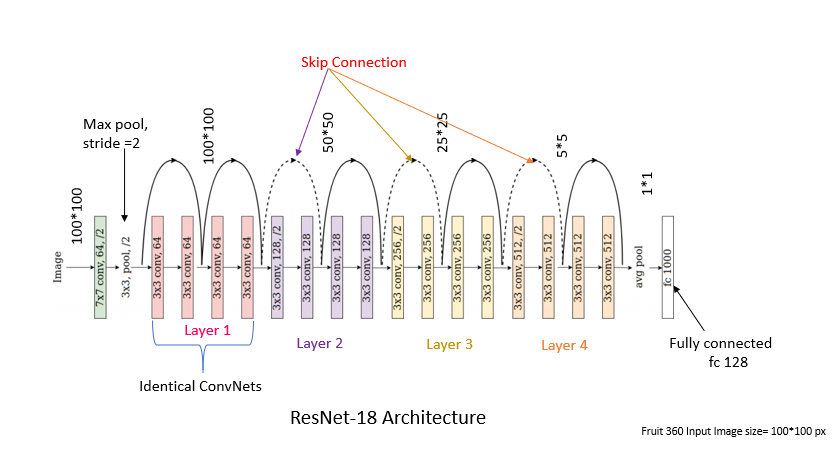

ResNet18 is made of 6 parts 
- **[conv1, bn1, relu, maxpool] block**
- **4 layers of residual blocks**
- **Head consisting of [avgpool + fc]**

We want to know the number of FLOPs, parameters... for each section of the model, considering a dummy input.

In [17]:
model = resnet18().to(device)
model.eval()

import torch.nn as nn

resnet18_sections = [ nn.Sequential(*[model.conv1, model.bn1, model.maxpool]).to(device),
                      model.layer1.to(device),
                      model.layer2.to(device),
                      model.layer3.to(device),
                      model.layer4.to(device),
                      nn.Sequential(*[model.avgpool, nn.Flatten(1), model.fc]).to(device)]

resnet18_section_inputs = [ input,
                            torch.rand(2,64,56,56).to(device),
                            torch.rand(2,64,56,56).to(device),
                            torch.rand(2,128,28,28).to(device),
                            torch.rand(2,256,14,14).to(device),
                            torch.rand(2,512,7,7).to(device)]

for i, (section,section_input) in enumerate(zip(resnet18_sections, resnet18_section_inputs)):
  _, section_FLOPs, section_params = get_metrics(section, section_input)
  print(f"Section {i+1} = {round(section_FLOPs,3)} MFLOPs and {round(section_params,3)} M parameters")  

Section 1 = 478.478 MFLOPs and 0.01 M parameters
Section 2 = 1856.111 MFLOPs and 0.148 M parameters
Section 3 = 1648.181 MFLOPs and 0.526 M parameters
Section 4 = 1646.174 MFLOPs and 2.1 M parameters
Section 5 = 1645.171 MFLOPs and 8.394 M parameters
Section 6 = 2.15 MFLOPs and 0.513 M parameters


thop_library/thop/vision/basic_hooks.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  kernel = torch.DoubleTensor([*(x[0].shape[2:])]) // torch.DoubleTensor([*(y.shape[2:])])


### Observations
- **Layers 1 to 4 contribute majorly to model FLOPs and parameters**.
- Section 3 (layer3) and Section 6 (avgpool + fc layer) have similar number of parameters but **the FLOPs for the convolution part is superior than the fc part**.
- As we'll see later, **Convolutional layers have generally fewer parameters but consume more time** (as indicated by higher FLOPs) compared to **Linear layers**.
